In [1]:
from scipy.integrate import solve_ivp
import numpy as np

In [2]:
def covid_model_ga(t, y, pars, agepars):
    
    dydt = np.zeros(len(y))
    
    # Total asymptomatic
    Ia = sum(y[agepars["Ia_ids"]])
    
    # Total symptomatic
    Is = sum(y[agepars["Is_ids"]])
    
    # Total recovered
    R = sum(y[agepars["R_ids"]])
    
    # Total susceptible
    S = sum(y[agepars["S_ids"]])
    
    # Total exposed
    E = sum(y[agepars["E_ids"]])

    # Dynamics -  Base Model
    
    # Susceptible
    dydt[agepars["S_ids"]] = -pars["beta_a"] * y[agepars["S_ids"]] * Ia - \
                            pars["beta_s"] * y[agepars["S_ids"]] * Is
    
    # Exposed
    dydt[agepars["E_ids"]] = pars["beta_a"] * y[agepars["S_ids"]] * Ia + \
                            pars["beta_s"] * y[agepars["S_ids"]] * Is - pars["gamma_e"] * y[agepars["E_ids"]]
    
    # Infectious asymptomatically
    dydt[agepars["Ia_ids"]] = np.transpose(pars["p"]) * pars["gamma_e"] * y[agepars["E_ids"]] - \
                            pars["gamma_a"] * y[agepars["Ia_ids"]]
    
    # Infectious symptomatically
    dydt[agepars["Is_ids"]] = np.transpose(np.ones(len(pars["p"])) - pars["p"]) * pars["gamma_e"] * \
                            y[agepars["E_ids"]] - pars["gamma_s"] * y[agepars["Is_ids"]]
    
    # Symptomatic cases requiring hospital care (subacute)
    dydt[agepars["Ihsub_ids"]]= np.transpose(agepars["hosp_frac"]) * (1 - np.transpose(agepars["hosp_crit"])) * \
                            pars["gamma_s"] * y[agepars["Is_ids"]] - pars["gamma_h"] * y[agepars["Ihsub_ids"]]
    
    # Symptomatic cases requiring ICU intervention (acute/critical)
    dydt[agepars["Ihcri_ids"]]= np.transpose(agepars["hosp_frac"]) * np.transpose(agepars["hosp_crit"]) * \
                            pars["gamma_s"] * y[agepars["Is_ids"]] - pars["gamma_h"] * y[agepars["Ihcri_ids"]]
    
    # Recovered
    dydt[agepars["R_ids"]]= pars["gamma_a"] * y[agepars["Ia_ids"]] + \
                            pars["gamma_s"] * y[agepars["Is_ids"]] * (1 - np.transpose(agepars["hosp_frac"])) + \
                            pars["gamma_h"] * y[agepars["Ihsub_ids"]] + \
                            pars["gamma_h"] * y[agepars["Ihcri_ids"]] * (1 - np.transpose(agepars["crit_die"]))
    
    # Deaths
    dydt[agepars["D_ids"]] = pars["gamma_h"] * y[agepars["Ihcri_ids"]] * np.transpose(agepars["crit_die"])
    
    # HFR. Hospitalization fatality risk. Infectious and hospitalized
    dydt[agepars["Hcum_ids"]]= np.transpose(agepars["hosp_frac"]) * (1 - np.transpose(agepars["hosp_crit"])) * \
                            pars["gamma_s"] * y[agepars["Is_ids"]] + np.transpose(agepars["hosp_frac"]) * \
                            np.transpose(agepars["hosp_crit"]) * pars["gamma_s"] * y[agepars["Is_ids"]]
    # Is it the same as?
    #dydt[agepars["Hcum_ids"]]= np.transpose(agepars["hosp_frac"]) * pars["gamma_s"] * y[agepars["Is_ids"]] 

    return dydt

### Population

In [3]:
agepars = {}
# Age groups
agepars["meanage"] = np.arange(5, 96, 10)
agepars["highage"] = np.arange(9, 100, 10)
agepars["lowage"] = np.arange(0, 91, 10)

In [4]:
# From 2018 Census
population = {}
population["N"] = 10666108;
# Age population fractions
population["agefrac"] = np.array([0.126, 0.137, 0.139, 0.132, 0.130, 0.129, 0.104, 0.061, 0.036, 0.007]);
# Must sum to 1
population["agefrac"] = population["agefrac"]/sum(population["agefrac"])
population["meanage"] = sum(agepars["meanage"] * population["agefrac"])

### Parameters


In [5]:
pars = {}

#From exposed to infectious. 1/gamma_e = mean exposed period
pars["gamma_e"] = 1/4

#From asymptomatic to recovered. Resolution rate for asymptomatic. 1/gamma_a = mean asymptomatic period
pars["gamma_a"] = 1/6

#From symptomatic to recovered. Resolution rate for symptomatic. 1/gamma_s = mean symptomatic period
pars["gamma_s"] = 1/6

#From subacute to recovered. 1/gamma_h = mean hospital period
pars["gamma_h"] = 1/10

#From susceptible to asymptomatic exposed. beta_a = transmission for asymptomatic
pars["beta_a"] = 4/10

#From susceptible to symptomatic exposed. beta_s = transmission for symptomatic
pars["beta_s"] = 8/10

#Fraction of asymptomatic per age group
pars["p"] = np.array([0.95, 0.95, 0.90, 0.8, 0.7, 0.6, 0.4, 0.2, 0.2, 0.2])
pars["overall_p"] = sum(pars["p"] * population["agefrac"])
pars["Itrigger"] = 500000/population["N"]

In [6]:
agepars["num_ages"]  = len(agepars["meanage"]);
N = agepars["num_ages"]

# Fraction of hospitalized individuals per age group 
agepars["hosp_frac"] = np.array([0.1, 0.3, 1.2, 3.2, 4.9, 10.2, 16.6, 24.3, 27.3, 27.3])/100

# Fraction of ICU needed given hospitalization
agepars["hosp_crit"] = np.array([5, 5, 5, 5, 6.3, 12.2, 27.4, 43.2, 70.9, 70.9])/100

# Fraction of deaths given ICU
agepars["crit_die"] = 0.5 * np.ones(N);

# Set up indexes for each group 
agepars["S_ids"] = np.arange(0, N)
agepars["E_ids"] = np.arange(N, 2*N)
agepars["Ia_ids"] = np.arange(2*N, 3*N)
agepars["Is_ids"] = np.arange(3*N, 4*N)
agepars["Ihsub_ids"] = np.arange(4*N, 5*N)
agepars["Ihcri_ids"] = np.arange(5*N, 6*N)
agepars["R_ids"] = np.arange(6*N, 7*N)
agepars["D_ids"] = np.arange(7*N, 8*N)
agepars["Hcum_ids"] = np.arange(8*N, 9*N)

 ### Epidemiological parameters

In [7]:
# Transmission for asymptomatic / Resolution rate for asymptomatic
pars["Ra"] = pars["beta_a"]/pars["gamma_a"]

# Transmission for symptomatic / Resolution rate for symptomatic
pars["Rs"] = pars["beta_s"]/pars["gamma_s"]

# Basic reproduction number
# If no age stratification: 
# pars["R0"] = pars["p"] * pars["Ra"] + (1 - pars["p"]) * pars["Rs"]

# With age stratification:
pars["R0"] = sum(pars["p"] * population["agefrac"] * pars["Ra"] + 
                 (1 - pars["p"]) * population["agefrac"] * pars["Rs"])

### Init the population - baseline


In [8]:
tmpzeros = np.zeros(N)

outbreak = {}
outbreak["y0"] = np.concatenate((population["agefrac"], tmpzeros, tmpzeros,
                                 tmpzeros, tmpzeros, tmpzeros, tmpzeros, tmpzeros, tmpzeros), axis = None)

# Initiate an outbreak
# Remove one person from the Susceptible population, third age group
# Move that person to the Exposed population, third age group
outbreak["y0"] = population["N"] * outbreak["y0"]
outbreak["y0"][2] = outbreak["y0"][2]-1
outbreak["y0"][12] = 1
outbreak["y0"] = outbreak["y0"]/population["N"]
outbreak["pTime"] = 365
outbreak["pNear"] = 30
outbreak["pshift"] =  0

In [10]:
def intervene_trigger(t, y, pars, agepars):
    itot = 1 - sum(y[agepars["S_ids"]])
    value = itot - pars["Itrigger"]
    return(value)
intervene_trigger.terminal = True
intervene_trigger.direction = 0

### Simulation

In [11]:
sol_pre = solve_ivp(covid_model_ga, (0, outbreak["pTime"] + 1), outbreak["y0"], \
                    t_eval = np.arange(0, outbreak["pTime"] + 1 , 1), \
                    args = (pars,agepars), reltol = 1e-8, max_step = 0.1, events = intervene_trigger)

/labs/csbig/dgarcia-covid/miniconda3/envs/model-covid/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:40: UserWarning: The following arguments have no effect for a chosen solver: `reltol`.
  warn("The following arguments have no effect for a chosen solver: {}."


In [43]:
stats = {}
# HFR. Hospitalization fatality risk. Infectious and hospitalized
stats["Hcum"] = sum(sol_pre.y[agepars["Hcum_ids"], :])
# Deaths
stats["Dcum"] = sum(sol_pre.y[agepars["D_ids"], :])

In [23]:
sol_pre.t_events

[array([86.03242901])]

In [24]:
te = sol_pre.t_events[0][0]

# Plots

In [17]:
import matplotlib.pyplot as plt
import datetime
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter

In [29]:
day_base = datetime.date.today()
dates = [day_base + datetime.timedelta(days=int(x)) for x in range(-int(te), 10, 11)]       
dates.sort()                                                             

In [31]:
ga_cases  = [552, 620, 800, 1097, 1387, 1643, 2198]
ga_hosp =  [186, 240, 361, 438, 509, 607, 660]
ga_death = [25, 25, 38, 47, 56, 65, 79]
ga_date = [day_base + datetime.timedelta(days=int(x)) for x in range(-6, 1)]       

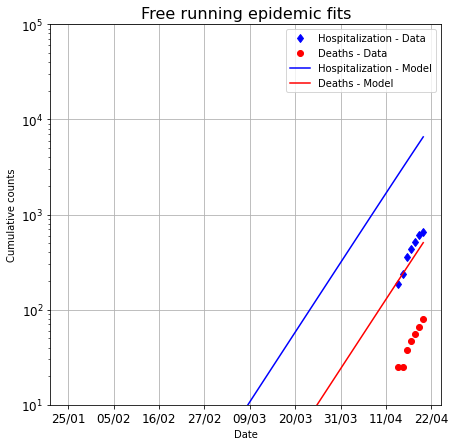

In [48]:
date_form = DateFormatter("%d/%m")

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)


ax.semilogy(ga_date, ga_hosp, 'bd', label = "Hospitalization - Data")
ax.semilogy(ga_date, ga_death, 'ro', label = "Deaths - Data")

ax.semilogy([day_base + datetime.timedelta(days=-int(te) + int(x)) for x in sol_pre.t], \
        stats["Hcum"]*population["N"], 'b-', label = "Hospitalization - Model")

ax.semilogy([day_base + datetime.timedelta(days=-int(te) + int(x)) for x in sol_pre.t], \
        stats["Dcum"]*population["N"], 'r-', label = "Deaths - Model")

ax.set(xlabel = 'Date', ylabel = 'Cumulative counts', ylim = (10e0,10e4))
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.set_xticks(dates)
plt.rc('axes', titlesize = 16)
plt.rc('xtick', labelsize = 12)   
plt.rc('ytick', labelsize = 12)

plt.grid(which = "major")
plt.legend()
plt.title("""Free running epidemic fits""")
plt.show()